<a href="https://colab.research.google.com/github/sivabala08/Control-A-Cursor-Using-Eyes/blob/main/Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [341]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic-machine-learning-from-disaster:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3064%2F5101%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240830%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240830T160213Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D691e9e4c3c3d0bc79008d34d9d9da1835bffd49330261316326bdb5d674c2dbea4d19b28c51aebfeee77236fd769fc7004151c98fc538b06e01d486f43b5ec21229cea3b3554060734bcc7182d461c0af007ad947f5b3b7ba1e1d814bc5cfba9242cf228940027b8e199d13e3e652aaf19718b706231246b6185b35778a62dae7133250baa18619fef81f57cd4e9f79761d5f4f8470cd926fc0fdcbe2d4913be4521ebb9ea233c8b2370929ba8796a52b94f8f713829186667db53c250af6168c488c95b6a83ecc23f05d24b7613bb01d945c1f231b52e752a23faf14d66e39c4297f09f0f810e54ea1f6d5dcae345eaa1eeda34b975d91f9c376c786109177f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 33847 bytes downloaded
Downloaded and uncompressed: titanic-machine-learning-from-disaster
Data source import complete.


In [342]:
import pandas as pd
import numpy as np
# Data visualization libraries
import seaborn as sb
import matplotlib.pyplot as plt

# sklearn provides a wide range of utilities for preprocessing data before training machine learning models.
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Model evaluation and selection
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV


# Importing libraries:

Here's a one-liner summary of each function or class:

1. **`pandas` (`pd`)**: Data manipulation and analysis library with DataFrame support.
2. **`numpy` (`np`)**: Numerical computations with support for arrays and matrices.
3. **`seaborn` (`sb`)**: Statistical data visualization library.
4. **`matplotlib.pyplot` (`plt`)**: Core plotting library for visualizations.
5. **`OrdinalEncoder` & `OneHotEncoder`**: Convert categorical data to numerical format.
6. **`SimpleImputer`**: Fill missing data using a specified strategy.
7. **`make_column_transformer`**: Apply different transformations to specific DataFrame columns.
8. **`Pipeline` & `make_pipeline`**: Chain multiple preprocessing steps with a model in a sequence.
9. **`LogisticRegression`, `SVC`, `RandomForestClassifier`, `DecisionTreeClassifier`, `KNeighborsClassifier`, `GaussianNB`**: Machine learning models for classification tasks.
10. **`cross_val_score`, `StratifiedKFold`, `train_test_split`, `GridSearchCV`**: Tools for model evaluation, data splitting, and hyperparameter tuning.

# Importing the Files

In [343]:
train_data=pd.read_csv('/kaggle/input/titanic-machine-learning-from-disaster/train.csv')
test_data=pd.read_csv('/kaggle/input/titanic-machine-learning-from-disaster/test.csv')

# Exploring Data:

In [344]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [345]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [346]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [347]:
train_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [348]:
train_data.groupby(['Pclass','Survived'])['Survived'].mean()


Pclass  Survived
1       0           0.0
        1           1.0
2       0           0.0
        1           1.0
3       0           0.0
        1           1.0
Name: Survived, dtype: float64

In [349]:
train_data.groupby(['Pclass','Survived'])['Survived'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

In [350]:
train_data.groupby(['SibSp','Survived'])['Survived'].mean()


SibSp  Survived
0      0           0.0
       1           1.0
1      0           0.0
       1           1.0
2      0           0.0
       1           1.0
3      0           0.0
       1           1.0
4      0           0.0
       1           1.0
5      0           0.0
8      0           0.0
Name: Survived, dtype: float64

In [351]:
train_data.groupby(['SibSp','Survived'])['Survived'].count()


SibSp  Survived
0      0           398
       1           210
1      0            97
       1           112
2      0            15
       1            13
3      0            12
       1             4
4      0            15
       1             3
5      0             5
8      0             7
Name: Survived, dtype: int64

In [352]:
train_data.groupby(['SibSp'],as_index=False)['Survived'].mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [353]:
train_data.groupby(['Parch'],as_index=False)['Survived'].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [354]:
train_data['Famil_size']= train_data['SibSp']+train_data['Parch']+1
test_data['Famil_size']=test_data['SibSp']+test_data['Parch']+1

In [355]:
train_data.groupby(['Famil_size'],as_index=False)['Survived'].mean()

,Famil_size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [356]:
family={1:'Alone',2:'Small',3:'Small',4:'Medium',5:'Medium',6:'Large',7:'Large',8:'Large'}
train_data['Famil_size']=train_data['Famil_size'].map(family)
test_data['Famil_size']=test_data['Famil_size'].map(family)

In [357]:
train_data.groupby(['Famil_size'],as_index=False)['Survived'].mean()

,Famil_size,Survived
0,Alone,0.303538
1,Large,0.175000
2,Medium,0.545455
3,Small,0.562738


In [358]:
train_data.groupby(['Embarked'],as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


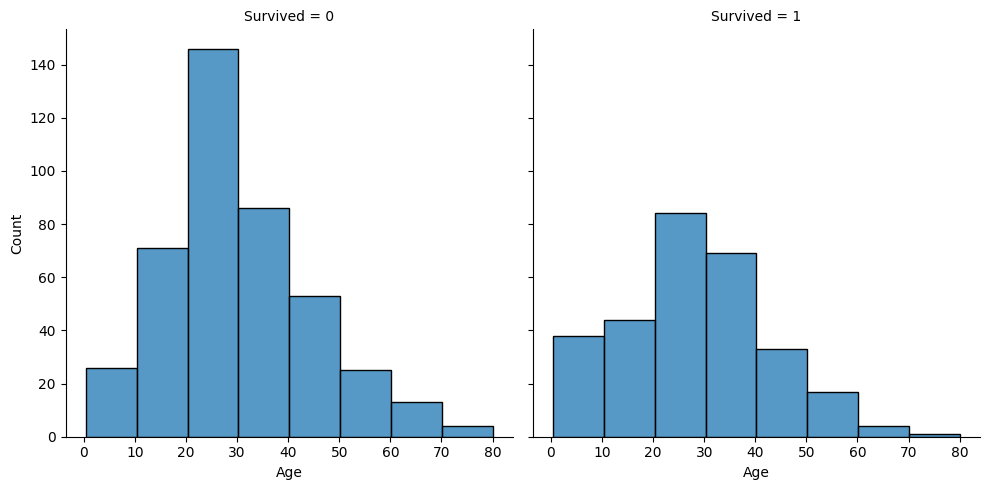

In [359]:
sb.displot(train_data, x='Age', col='Survived', binwidth=10, height=5)

In [360]:
train_data['Age_c']=pd.qcut(train_data['Age'], 8)
test_data['Age_c']=pd.qcut(test_data['Age'], 8)

In [361]:
train_data.groupby(['Age_c'],as_index=False)['Survived'].mean()

<ipython-input-361-b94d2bb05789>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_data.groupby(['Age_c'],as_index=False)['Survived'].mean()


,Age_c,Survived
0,"(0.419, 16.0]",0.550000
1,"(16.0, 20.125]",0.341772
2,"(20.125, 24.0]",0.367347
3,"(24.0, 28.0]",0.352941
4,"(28.0, 32.312]",0.416667
5,"(32.312, 38.0]",0.450549
6,"(38.0, 47.0]",0.329545
7,"(47.0, 80.0]",0.415730


In [362]:
train_data.loc[train_data['Age'] <= 16, 'Age'] = 0
train_data.loc[(train_data['Age'] > 16) & (train_data['Age'] <= 20.125), 'Age'] = 1
train_data.loc[(train_data['Age'] > 20.125) & (train_data['Age'] <= 24), 'Age'] = 2
train_data.loc[(train_data['Age'] > 24) & (train_data['Age'] <= 28), 'Age'] = 3
train_data.loc[(train_data['Age'] > 28) & (train_data['Age'] <= 32.312), 'Age'] = 4
train_data.loc[(train_data['Age'] > 32.312) & (train_data['Age'] <= 38), 'Age'] = 5
train_data.loc[(train_data['Age'] > 38) & (train_data['Age'] <= 47), 'Age'] = 6
train_data.loc[(train_data['Age'] > 47) & (train_data['Age'] <= 80), 'Age'] = 7
# train_data.loc[train_data['Age'] > 80, 'Age']
test_data.loc[test_data['Age'] <= 16, 'Age'] = 0
test_data.loc[(test_data['Age'] > 16) & (test_data['Age'] <= 20.125), 'Age'] = 1
test_data.loc[(test_data['Age'] > 20.125) & (test_data['Age'] <= 24), 'Age'] = 2
test_data.loc[(test_data['Age'] > 24) & (test_data['Age'] <= 28), 'Age'] = 3
test_data.loc[(test_data['Age'] > 28) & (test_data['Age'] <= 32.312), 'Age'] = 4
test_data.loc[(test_data['Age'] > 32.312) & (test_data['Age'] <= 38), 'Age'] = 5
test_data.loc[(test_data['Age'] > 38) & (test_data['Age'] <= 47), 'Age'] = 6
test_data.loc[(test_data['Age'] > 47) & (test_data['Age'] <= 80), 'Age'] = 7
# test_data.loc[test_data['Age'] > 80, 'Age']

In [363]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Famil_size,Age_c
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,7.2500,NaN,S,Small,"(20.125, 24.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,5.0,1,0,PC 17599,71.2833,C85,C,Small,"(32.312, 38.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,3.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Alone,"(24.0, 28.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,5.0,1,0,113803,53.1000,C123,S,Small,"(32.312, 38.0]"
4,5,0,3,"Allen, Mr. William Henry",male,5.0,0,0,373450,8.0500,NaN,S,Alone,"(32.312, 38.0]"


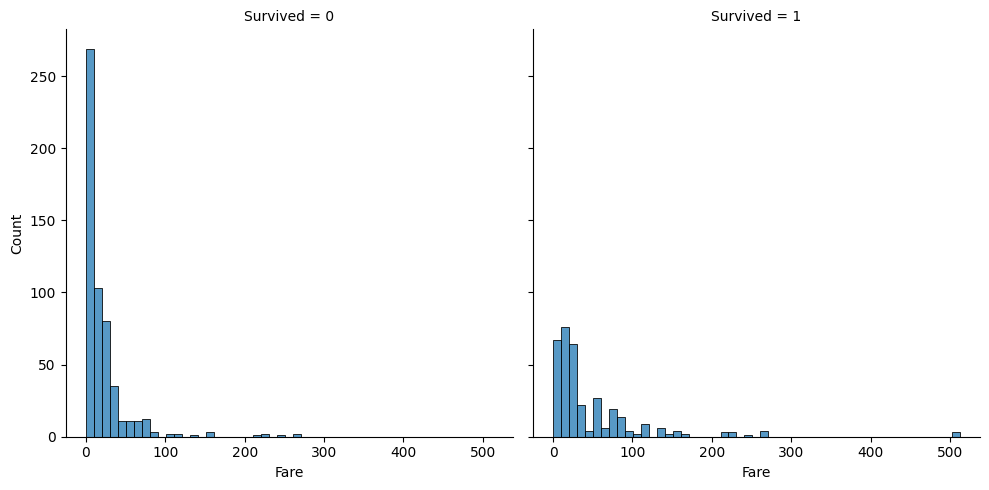

In [364]:
sb.displot(train_data, x='Fare', col='Survived', binwidth=10, height=5)

In [365]:
train_data['Fare_c']=pd.qcut(train_data['Fare'], 6)
test_data['Fare_c']=pd.qcut(test_data['Fare'], 6)

In [366]:
train_data.groupby(['Fare_c'],as_index=False)['Survived'].mean()

<ipython-input-366-6028c19279c4>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_data.groupby(['Fare_c'],as_index=False)['Survived'].mean()


,Fare_c,Survived
0,"(-0.001, 7.775]",0.205128
1,"(7.775, 8.662]",0.190789
2,"(8.662, 14.454]",0.366906
3,"(14.454, 26.0]",0.436242
4,"(26.0, 52.369]",0.417808
5,"(52.369, 512.329]",0.697987


In [367]:
train_data.loc[train_data['Fare'] <= 7.775, 'Fare'] = 0
train_data.loc[(train_data['Fare'] > 7.775) & (train_data['Fare'] <= 8.662), 'Fare'] = 1
train_data.loc[(train_data['Fare'] > 8.662) & (train_data['Fare'] <= 14.454), 'Fare'] = 2
train_data.loc[(train_data['Fare'] > 14.454) & (train_data['Fare'] <= 26), 'Fare'] = 3
train_data.loc[(train_data['Fare'] > 26) & (train_data['Fare'] <= 52.369), 'Fare'] = 4
train_data.loc[(train_data['Fare'] > 52.369) & (train_data['Fare'] <= 512.329), 'Fare'] = 5
train_data.loc[train_data['Fare'] > 512.329, 'Fare']

test_data.loc[test_data['Fare'] <= 7.775, 'Fare'] = 0
test_data.loc[(test_data['Fare'] > 7.775) & (test_data['Fare'] <= 8.662), 'Fare'] = 1
test_data.loc[(test_data['Fare'] > 8.662) & (test_data['Fare'] <= 14.454), 'Fare'] = 2
test_data.loc[(test_data['Fare'] > 14.454) & (test_data['Fare'] <= 26), 'Fare'] = 3
test_data.loc[(test_data['Fare'] > 26) & (test_data['Fare'] <= 52.369), 'Fare'] = 4
test_data.loc[(test_data['Fare'] > 52.369) & (test_data['Fare'] <= 512.329), 'Fare'] = 5
test_data.loc[test_data['Fare'] > 512.329, 'Fare']

,Fare
343,512.3292


In [368]:
train_data['Name']

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"
...,...
886,"Montvila, Rev. Juozas"
887,"Graham, Miss. Margaret Edith"
888,"Johnston, Miss. Catherine Helen ""Carrie"""
889,"Behr, Mr. Karl Howell"


In [369]:
train_data['Title'] = train_data['Name'].str.split(pat=", ", expand=True)[1].str.split(".", expand=True)[0].apply(lambda x: x.strip())
test_data['Title']=train_data['Name'].str.split(pat=", ",expand=True)[1].str.split(pat=".",expand=True)[0].apply(lambda x: x.strip())

In [370]:
train_data.groupby(['Title'], as_index=False)['Survived'].mean()

,Title,Survived
0,Capt,0.000000
1,Col,0.500000
2,Don,0.000000
3,Dr,0.428571
4,Jonkheer,0.000000
5,Lady,1.000000
6,Major,0.500000
7,Master,0.575000
8,Miss,0.697802
9,Mlle,1.000000


In [371]:
train_data["Title"]=train_data["Title"].replace({
    "Capt":"Officer",
    "Col":"Officer",
    "Major":"Officer",
    "the Countless":"Royalty",
    "Jonkheer":"Royalty",
    "Don":"Royalty",
    "Sir":"Royalty",
    "Dr":"Officer",
    "Rev":"Officer",
    "Mlle":"Royalty","Mme":"Royalty","Ms":"Royalty"})
test_data["Title"]=test_data["Title"].replace({
    "Capt":"Officer",
    "Col":"Officer",
    "Major":"Officer",
    "the Countless":"Royalty",
    "Jonkheer":"Royalty",
    "Don":"Royalty",
    "Sir":"Royalty",
    "Dr":"Officer",
    "Rev":"Officer",
    "Mlle":"Royalty","Mme":"Royalty","Ms":"Royalty"})

In [372]:
train_data.groupby(['Title'], as_index=False)['Survived'].mean()

,Title,Survived
0,Lady,1.000000
1,Master,0.575000
2,Miss,0.697802
3,Mr,0.156673
4,Mrs,0.792000
5,Officer,0.277778
6,Royalty,0.714286
7,the Countess,1.000000


In [373]:
train_data.groupby(['Title'], as_index=False)['Survived'].agg(['count','mean'])

,Title,count,mean
0,Lady,1,1.000000
1,Master,40,0.575000
2,Miss,182,0.697802
3,Mr,517,0.156673
4,Mrs,125,0.792000
5,Officer,18,0.277778
6,Royalty,7,0.714286
7,the Countess,1,1.000000


In [374]:
train_data['Name_Length'] = train_data['Name'].apply(lambda x: len(str(x)))
test_data['Name_Length'] = test_data['Name'].apply(lambda x: len(str(x)))

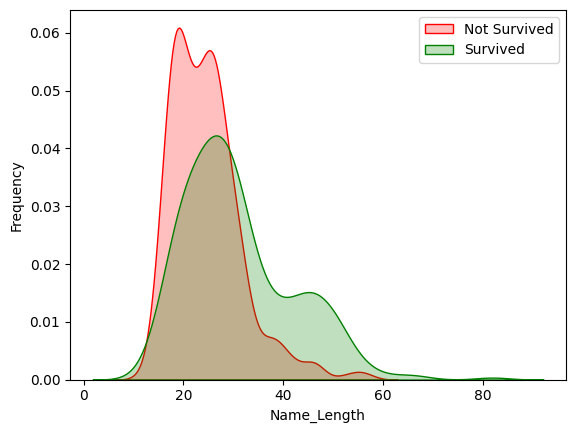

In [375]:
a = sb.kdeplot(train_data['Name_Length'][(train_data['Survived']==0) & (train_data['Name_Length'].notnull())],color='Red', fill=True)
a= sb.kdeplot(train_data['Name_Length'][(train_data['Survived']==1) & (train_data['Name_Length'].notnull())],ax=a,color='Green', fill=True)
a.set_xlabel('Name_Length')
a.set_ylabel('Frequency')
a= a.legend(['Not Survived', 'Survived'])

In [376]:
train_data['Name_Lgp']=pd.qcut(train_data['Name_Length'],6)
test_data['Name_Lgp']=pd.qcut(test_data['Name_Length'],6)

In [377]:
train_data.groupby(['Name_Lgp'], as_index=False)['Survived'].mean()

<ipython-input-377-5f07d4df6916>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_data.groupby(['Name_Lgp'], as_index=False)['Survived'].mean()


,Name_Lgp,Survived
0,"(11.999, 19.0]",0.220588
1,"(19.0, 22.0]",0.307692
2,"(22.0, 25.0]",0.328467
3,"(25.0, 28.0]",0.316901
4,"(28.0, 33.0]",0.479167
5,"(33.0, 82.0]",0.693878


In [378]:
train_data.loc[train_data['Name_Length'] <= 11.999, 'Name_Size'] = 0
train_data.loc[(train_data['Name_Length'] > 11.667) & (train_data['Name_Length'] <= 19.0), 'Name_Size'] = 1
train_data.loc[(train_data['Name_Length'] > 19.0) & (train_data['Name_Length'] <= 22.0), 'Name_Size'] = 2
train_data.loc[(train_data['Name_Length'] > 22.0) & (train_data['Name_Length'] <= 25.0), 'Name_Size'] = 3
train_data.loc[(train_data['Name_Length'] > 25.0) & (train_data['Name_Length'] <= 28.5), 'Name_Size'] = 4
train_data.loc[(train_data['Name_Length'] > 28.0) & (train_data['Name_Length'] <= 33.0), 'Name_Size'] = 5
train_data.loc[(train_data['Name_Length'] > 33.0) & (train_data['Name_Length'] <= 82.0), 'Name_Size'] =6
train_data.loc[train_data['Name_Length'] > 82.0 , 'Name_Length']

test_data.loc[test_data['Name_Length'] <= 11.999, 'Name_Size'] = 0
test_data.loc[(test_data['Name_Length'] > 11.667) & (test_data['Name_Length'] <= 19.0), 'Name_Size'] = 1
test_data.loc[(test_data['Name_Length'] > 19.0) & (test_data['Name_Length'] <= 22.0), 'Name_Size'] = 2
test_data.loc[(test_data['Name_Length'] > 22.0) & (test_data['Name_Length'] <= 25.0), 'Name_Size'] = 3
test_data.loc[(test_data['Name_Length'] > 25.0) & (test_data['Name_Length'] <= 28.5), 'Name_Size'] = 4
test_data.loc[(test_data['Name_Length'] > 28.0) & (test_data['Name_Length'] <= 33.0), 'Name_Size'] = 5
test_data.loc[(test_data['Name_Length'] > 33.0) & (test_data['Name_Length'] <= 82.0), 'Name_Size'] =6
test_data.loc[test_data['Name_Length'] > 82.0 , 'Name_Length']


,Name_Length


In [379]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Famil_size,Age_c,Fare_c,Title,Name_Length,Name_Lgp,Name_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,0.0,NaN,S,Small,"(20.125, 24.0]","(-0.001, 7.775]",Mr,23,"(22.0, 25.0]",3.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,5.0,1,0,PC 17599,5.0,C85,C,Small,"(32.312, 38.0]","(52.369, 512.329]",Mrs,51,"(33.0, 82.0]",6.0
2,3,1,3,"Heikkinen, Miss. Laina",female,3.0,0,0,STON/O2. 3101282,1.0,NaN,S,Alone,"(24.0, 28.0]","(7.775, 8.662]",Miss,22,"(19.0, 22.0]",2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,5.0,1,0,113803,5.0,C123,S,Small,"(32.312, 38.0]","(52.369, 512.329]",Mrs,44,"(33.0, 82.0]",6.0
4,5,0,3,"Allen, Mr. William Henry",male,5.0,0,0,373450,1.0,NaN,S,Alone,"(32.312, 38.0]","(7.775, 8.662]",Mr,24,"(22.0, 25.0]",3.0


In [380]:
train_data['Ticket']

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450
...,...
886,211536
887,112053
888,W./C. 6607
889,111369


In [381]:
train_data['Ticket_no']=train_data['Ticket'].apply(lambda x: pd.Series({'Ticket':x.split()[-1]}))
test_data['Ticket_no']=test_data['Ticket'].apply(lambda x: pd.Series({'Ticket':x.split()[-1]}))

In [382]:
train_data.groupby(['Ticket_no'], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count',ascending=False)

,Ticket_no,count,mean
464,347082,7,0.000000
196,2343,7,0.000000
94,1601,7,0.714286
168,2144,6,0.000000
468,347088,6,0.000000
...,...,...,...
271,2662,1,0.000000
272,2663,1,1.000000
273,2664,1,0.000000
276,2667,1,1.000000


In [383]:
train_data.groupby('Ticket_no')['Ticket_no'].transform('count')

,Ticket_no
0,1
1,1
2,1
3,2
4,1
...,...
886,1
887,1
888,2
889,1


In [384]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Famil_size,Age_c,Fare_c,Title,Name_Length,Name_Lgp,Name_Size,Ticket_no
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,0.0,NaN,S,Small,"(20.125, 24.0]","(-0.001, 7.775]",Mr,23,"(22.0, 25.0]",3.0,21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,5.0,1,0,PC 17599,5.0,C85,C,Small,"(32.312, 38.0]","(52.369, 512.329]",Mrs,51,"(33.0, 82.0]",6.0,17599
2,3,1,3,"Heikkinen, Miss. Laina",female,3.0,0,0,STON/O2. 3101282,1.0,NaN,S,Alone,"(24.0, 28.0]","(7.775, 8.662]",Miss,22,"(19.0, 22.0]",2.0,3101282
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,5.0,1,0,113803,5.0,C123,S,Small,"(32.312, 38.0]","(52.369, 512.329]",Mrs,44,"(33.0, 82.0]",6.0,113803
4,5,0,3,"Allen, Mr. William Henry",male,5.0,0,0,373450,1.0,NaN,S,Alone,"(32.312, 38.0]","(7.775, 8.662]",Mr,24,"(22.0, 25.0]",3.0,373450


In [385]:
train_data['Ticket']

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450
...,...
886,211536
887,112053
888,W./C. 6607
889,111369


In [386]:
train_data['Ticket_no'] = train_data['Ticket'].apply(lambda x: x.split()[-1])
test_data['Ticket_no'] = test_data['Ticket'].apply(lambda x: x.split()[-1])

In [387]:
train_data.groupby(['Ticket_no'], as_index=False)['Survived'].agg(['count','mean']).sort_values('count', ascending=False)

,Ticket_no,count,mean
464,347082,7,0.000000
196,2343,7,0.000000
94,1601,7,0.714286
168,2144,6,0.000000
468,347088,6,0.000000
...,...,...,...
271,2662,1,0.000000
272,2663,1,1.000000
273,2664,1,0.000000
276,2667,1,1.000000


In [388]:
train_data.groupby('Ticket_no')['Ticket_no'].transform('count')

,Ticket_no
0,1
1,1
2,1
3,2
4,1
...,...
886,1
887,1
888,2
889,1


In [389]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Famil_size,Age_c,Fare_c,Title,Name_Length,Name_Lgp,Name_Size,Ticket_no
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,0.0,NaN,S,Small,"(20.125, 24.0]","(-0.001, 7.775]",Mr,23,"(22.0, 25.0]",3.0,21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,5.0,1,0,PC 17599,5.0,C85,C,Small,"(32.312, 38.0]","(52.369, 512.329]",Mrs,51,"(33.0, 82.0]",6.0,17599
2,3,1,3,"Heikkinen, Miss. Laina",female,3.0,0,0,STON/O2. 3101282,1.0,NaN,S,Alone,"(24.0, 28.0]","(7.775, 8.662]",Miss,22,"(19.0, 22.0]",2.0,3101282
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,5.0,1,0,113803,5.0,C123,S,Small,"(32.312, 38.0]","(52.369, 512.329]",Mrs,44,"(33.0, 82.0]",6.0,113803
4,5,0,3,"Allen, Mr. William Henry",male,5.0,0,0,373450,1.0,NaN,S,Alone,"(32.312, 38.0]","(7.775, 8.662]",Mr,24,"(22.0, 25.0]",3.0,373450


In [390]:
train_data.groupby('Ticket_no')['Ticket_no'].transform('count')

,Ticket_no
0,1
1,1
2,1
3,2
4,1
...,...
886,1
887,1
888,2
889,1


In [391]:
train_data['Ticket_counts']=train_data.groupby('Ticket_no')['Ticket_no'].transform('count')
test_data['Ticket_counts']=test_data.groupby('Ticket_no')['Ticket_no'].transform('count')

In [392]:
train_data.groupby(['Ticket_counts'], as_index=False)['Survived'].agg(['count','mean']).sort_values('count', ascending=False)

,Ticket_counts,count,mean
0,1,544,0.295956
1,2,188,0.569149
2,3,66,0.712121
3,4,44,0.500000
6,7,21,0.238095
5,6,18,0.000000
4,5,10,0.000000


In [393]:
train_data['Ticket']

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450
...,...
886,211536
887,112053
888,W./C. 6607
889,111369


In [394]:
train_data['Ticket'].str.split(pat="",expand=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,A,/,5,,2,1,1,7,1,,None,None,None,None,None,None,None,None,None
1,,P,C,,1,7,5,9,9,,None,None,None,None,None,None,None,None,None,None
2,,S,T,O,N,/,O,2,.,,3,1,0,1,2,8,2,,None,None
3,,1,1,3,8,0,3,,None,None,None,None,None,None,None,None,None,None,None,None
4,,3,7,3,4,5,0,,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,,2,1,1,5,3,6,,None,None,None,None,None,None,None,None,None,None,None,None
887,,1,1,2,0,5,3,,None,None,None,None,None,None,None,None,None,None,None,None
888,,W,.,/,C,.,,6,6,0,7,,None,None,None,None,None,None,None,None
889,,1,1,1,3,6,9,,None,None,None,None,None,None,None,None,None,None,None,None


In [395]:
train_data['Ticket_location']= np.where(train_data['Ticket'].str.split(pat=" ",expand=True)[1].notna(), train_data['Ticket'].str.split(pat=" ", expand=True)[0].apply(lambda x:x.strip()),'Blank')
test_data['Ticket_location']= np.where(test_data['Ticket'].str.split(pat=" ",expand=True)[1].notna(), test_data['Ticket'].str.split(pat=" ", expand=True)[0].apply(lambda x:x.strip()),'Blank')

In [396]:
train_data['Ticket_location'].value_counts()

,count
Ticket_location,
Blank,665
PC,60
C.A.,27
STON/O,12
A/5,10
W./C.,9
CA.,8
SOTON/O.Q.,8
SOTON/OQ,7


In [397]:
train_data['Ticket_location'] = train_data['Ticket_location'].replace({
    'C.A.': 'CA',
    'W./C.': 'W/C',
    'CA.': 'CA',
    'SOTON/O.Q.': 'SOTON/OQ',
    'A/5.': 'A/5',
    'STON/O2.': 'STON/O2',
    'F.C.C.': 'FCC',
    'S.O.C.': 'SOC',
    'SC/PARIS': 'SC/Paris',
    'SC/Paris': 'Paris',
    'S.O./P.P.': 'SO/PP',
    'PP': 'PP',
    'A/4.': 'A/4',
    'A/4': 'A/4',
    'A./5.': 'A/5',
    'A.5.': 'A5',
    'S.C./PARIS': 'SC/Paris',
    'F.C.': 'FC',
    'S.W./PP': 'SW/PP',
    'S.C./A.4.': 'SC/A4',
    'S.O.P.': 'SOP',
    'A4.': 'A4',
    'W.E.P.': 'WEP',
    'S.P.': 'SP',
    'C.A./SOTON': 'CA/SOTON'
})
test_data['Ticket_location'] = test_data['Ticket_location'].replace({
    'C.A.': 'CA',
    'W./C.': 'W/C',
    'CA.': 'CA',
    'SOTON/O.Q.': 'SOTON/OQ',
    'A/5.': 'A/5',
    'STON/O2.': 'STON/O2',
    'F.C.C.': 'FCC',
    'S.O.C.': 'SOC',
    'SC/PARIS': 'SC/Paris',
    'SC/Paris': 'Paris',
    'S.O./P.P.': 'SO/PP',
    'PP': 'PP',
    'A/4.': 'A/4',
    'A/4': 'A/4',
    'A./5.': 'A/5',
    'A.5.': 'A5',
    'S.C./PARIS': 'SC/Paris',
    'F.C.': 'FC',
    'S.W./PP': 'SW/PP',
    'S.C./A.4.': 'SC/A4',
    'S.O.P.': 'SOP',
    'A4.': 'A4',
    'W.E.P.': 'WEP',
    'S.P.': 'SP',
    'C.A./SOTON': 'CA/SOTON'
})

In [398]:
train_data.groupby(['Ticket_location'], as_index=False)['Survived'].agg(['count','mean'])

,Ticket_location,count,mean
0,A/4,6,0.000000
1,A/5,19,0.105263
2,A/S,1,0.000000
3,A4,1,0.000000
4,A5,2,0.000000
5,Blank,665,0.383459
6,C,5,0.400000
7,CA,41,0.341463
8,CA/SOTON,1,0.000000
9,FC,1,0.000000


In [399]:
train_data['Cabin'] = train_data['Cabin'].fillna('U')
train_data['Cabin'] = train_data['Cabin'].apply(lambda i: i[0] if not pd.isnull(i) else 'x')

test_data['Cabin'] = test_data['Cabin'].fillna('U')
test_data['Cabin'] = test_data['Cabin'].apply(lambda i: i[0] if not pd.isnull(i) else 'x')

In [400]:
train_data.groupby(['Cabin'], as_index=False)['Survived'].agg(['count','mean'])

,Cabin,count,mean
0,A,15,0.466667
1,B,47,0.744681
2,C,59,0.593220
3,D,33,0.757576
4,E,32,0.750000
5,F,13,0.615385
6,G,4,0.500000
7,T,1,0.000000
8,U,687,0.299854


In [401]:
train_data['Cabin_Assigned']=train_data['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)
test_data['Cabin_Assigned']=test_data['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)

In [402]:
train_data.groupby(['Cabin_Assigned'],as_index=False)['Survived'].agg(['count','mean'])

,Cabin_Assigned,count,mean
0,0,687,0.299854
1,1,204,0.666667


In [403]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_c,Fare_c,Title,Name_Length,Name_Lgp,Name_Size,Ticket_no,Ticket_counts,Ticket_location,Cabin_Assigned
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,0.0,...,"(20.125, 24.0]","(-0.001, 7.775]",Mr,23,"(22.0, 25.0]",3.0,21171,1,A/5,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,5.0,1,0,PC 17599,5.0,...,"(32.312, 38.0]","(52.369, 512.329]",Mrs,51,"(33.0, 82.0]",6.0,17599,1,PC,1
2,3,1,3,"Heikkinen, Miss. Laina",female,3.0,0,0,STON/O2. 3101282,1.0,...,"(24.0, 28.0]","(7.775, 8.662]",Miss,22,"(19.0, 22.0]",2.0,3101282,1,STON/O2,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,5.0,1,0,113803,5.0,...,"(32.312, 38.0]","(52.369, 512.329]",Mrs,44,"(33.0, 82.0]",6.0,113803,2,Blank,1
4,5,0,3,"Allen, Mr. William Henry",male,5.0,0,0,373450,1.0,...,"(32.312, 38.0]","(7.775, 8.662]",Mr,24,"(22.0, 25.0]",3.0,373450,1,Blank,0


In [404]:
train_data.shape

(891, 23)

In [405]:
test_data.shape

(418, 22)

In [406]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      891 non-null    int64   
 1   Survived         891 non-null    int64   
 2   Pclass           891 non-null    int64   
 3   Name             891 non-null    object  
 4   Sex              891 non-null    object  
 5   Age              714 non-null    float64 
 6   SibSp            891 non-null    int64   
 7   Parch            891 non-null    int64   
 8   Ticket           891 non-null    object  
 9   Fare             891 non-null    float64 
 10  Cabin            891 non-null    object  
 11  Embarked         889 non-null    object  
 12  Famil_size       884 non-null    object  
 13  Age_c            714 non-null    category
 14  Fare_c           891 non-null    category
 15  Title            891 non-null    object  
 16  Name_Length      891 non-null    int64   
 1

In [407]:
train_data['Age'].fillna(train_data['Age'].mean(),inplace=True)
test_data['Age'].fillna(test_data['Age'].mean(),inplace=True)
test_data['Fare'].fillna(test_data['Fare'].mean(),inplace=True)


In [408]:
df = pd.DataFrame({
    'Age': [22, 25, np.nan, 29],
    'Sex': ['male', 'female', 'female', 'male'],
    'Embarked': ['S', 'C', 'Q', 'S'],
    'Pclass': [3, 1, 2, 1],
    'Fare': [7.25, 71.83, 8.05, 51.86],
    'Name_Size': [12, 15, 10, 18],
    'Cabin_Assigned': [0, 1, 0, 1],
    'Ticket_counts': [1, 2, 1, 3]
})


In [409]:
SI = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(sparse_output=False)
oe = OrdinalEncoder()

In [410]:
# Define the columns to be processed
oe_cols = ['Sex', 'Embarked']  # Columns for Ordinal Encoding
ohe_cols = []  # No columns for One-Hot Encoding based on your current DataFrame

In [411]:
x=train_data.drop(['Survived'], axis=1)
y=train_data['Survived']
x_test=test_data.drop(['Age_c','Fare_c'],axis=1)

In [412]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y,test_size=0.2,stratify=y,random_state=21)

In [413]:
# Pipelines for different types of transformations
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SI),       # Impute missing values
    ('ordinal', oe)        # Ordinal encoding
])

In [414]:
ohe_pipeline=ColumnTransformer(transformers=[
    'impute',SimpleImputer(strategy='most_frequent'),
    'OneHotEncoder',OneHotEncoder(handle_unknown='ignore',sparse_output=False)
])

In [415]:
ohe_pipeline = Pipeline(steps=[
    ('imputer', SI),
    ('onehot', ohe)
])

In [416]:
col_trans = ColumnTransformer(transformers=[
    ('impute', SI, ['Age']),
    ('ord_pipeline', ordinal_pipeline, oe_cols),
    ('ohe_pipeline', ohe_pipeline, ohe_cols),
    ('passthrough', 'passthrough', ['Pclass', 'Ticket_counts', 'Cabin_Assigned', 'Name_Size', 'Fare'])
], remainder='drop', n_jobs=-1)

In [417]:
print(df.columns)

Index(['Age', 'Sex', 'Embarked', 'Pclass', 'Fare', 'Name_Size',
       'Cabin_Assigned', 'Ticket_counts'],
      dtype='object')


In [418]:
transformed_data = col_trans.fit_transform(df)

In [419]:
rfc = RandomForestClassifier(max_depth=8)

In [420]:
param_grid = {
    'min_samples_leaf': [1, 2, 4],  # Correct parameter name
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt']
}

In [421]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

In [422]:
# Make pipeline with column transformer and GridSearchCV
pipefinalrfc = make_pipeline(col_trans, CV_rfc)
# Make pipeline with column transformer and GridSearchCV
pipefinalrfc = make_pipeline(col_trans, CV_rfc)


In [423]:
print(x_train.columns)

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Famil_size', 'Age_c', 'Fare_c',
       'Title', 'Name_Length', 'Name_Lgp', 'Name_Size', 'Ticket_no',
       'Ticket_counts', 'Ticket_location', 'Cabin_Assigned'],
      dtype='object')


In [424]:
pipefinalrfc.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Sex', 'Embarked']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequ...)),
                                                                  ('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  []),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Ticket_counts',
                                                   'Cabin_Assigned',
                                                   'Name_Size', 'Fare'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(max_depth=8),
                              n_jobs=-1,
                              param_grid={'max_features': ['auto', 'sqrt'],
                                          'min_samples_leaf': [1, 2, 4],
                                          'n_estimators': [100, 200]},
                              verbose=1))])

In [425]:
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}
0.8089924160346695


In [426]:
dtc=DecisionTreeClassifier()

In [427]:
param_grid={
    'min_samples_split':[5,10,15],
    'max_depth':[8,9,10,15,20],
    'min_samples_leaf':[1,2,4],
    'criterion':['gini','entropy'],
}

In [428]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [429]:
pipefinaldtc=make_pipeline(col_trans,CV_dtc)
pipefinaldtc.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Sex', 'Embarked']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequ...
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Ticket_counts',
                                                   'Cabin_Assigned',
                                                   'Name_Size', 'Fare'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=DecisionTreeClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [8, 9, 10, 15, 20],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [5, 10, 15]}))])

In [430]:
print(CV_dtc.best_params_)
print(CV_dtc.best_score_)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.8117797695262485


In [431]:
knn=KNeighborsClassifier()

In [432]:
param_grid={
    'n_neighbors':[3,5,7,9,11],
    'weights':['uniform','distance'],
    'algorithm':['auto','ball_tree','brute'],
    'p':[1,2],
}

In [433]:
CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [434]:
pipefinalknn = make_pipeline(col_trans, CV_dtc)
pipefinalknn.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Sex', 'Embarked']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequ...
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Ticket_counts',
                                                   'Cabin_Assigned',
                                                   'Name_Size', 'Fare'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=DecisionTreeClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [8, 9, 10, 15, 20],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [5, 10, 15]}))])

In [446]:
# Instantiate the SimpleImputer with the 'most_frequent' strategy
imputer = SimpleImputer(strategy='most_frequent')

# Fit and transform the training data
x_train_imputed = imputer.fit_transform(x_train)

In [476]:
pipefinalknn = make_pipeline(col_trans, CV_knn)  # Use CV_knn, not CV_dtc
pipefinalknn.fit(x_train, y_train)  # Fit on original x_train, not imputed


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Sex', 'Embarked']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequ...
                                                  []),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Ticket_counts',
                                                   'Cabin_Assigned',
                                                   'Name_Size', 'Fare'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=KNeighborsClassifier(),
                              param_grid={'algorithm': ['auto', 'ball_tree',
                                                        'brute'],
                                          'n_neighbors': [3, 5, 7, 9, 11],
                                          'p': [1, 2],
                                          'weights': ['uniform',
                                                      'distance']}))])

In [477]:
print(CV_knn.best_params_)
print(CV_knn.best_score_)

{'algorithm': 'brute', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.8005909583374372


In [449]:
svc=SVC()

In [451]:
param_grid={
    'C':[100,10,1.0,0.01,0.001],
    'kernel':['linear','rbf','rbf','sigmoid'],
}

In [453]:
CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [454]:
pipefinalsvc = make_pipeline(col_trans, CV_svc)
pipefinalsvc.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Sex', 'Embarked']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  []),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Ticket_counts',
                                                   'Cabin_Assigned',
                                                   'Name_Size', 'Fare'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(),
                              param_grid={'C': [100, 10, 1.0, 0.01, 0.001],
                                          'kernel': ['linear', 'rbf', 'rbf',
                                                     'sigmoid']}))])

In [455]:
print(CV_svc.best_params_)
print(CV_svc.best_score_)

{'C': 100, 'kernel': 'linear'}
0.7935191568994385


In [456]:
lr = LogisticRegression()

In [460]:
param_grid={
    'C':[100,10,1.0,0.01,0.001],
}

In [461]:
CV_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [462]:
pipefinallr = make_pipeline(col_trans, CV_lr)
pipefinallr.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Sex', 'Embarked']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  []),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Ticket_counts',
                                                   'Cabin_Assigned',
                                                   'Name_Size', 'Fare'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=LogisticRegression(),
                              param_grid={'C': [100, 10, 1.0, 0.01, 0.001]}))])

In [463]:
print(CV_lr.best_params_)
print(CV_lr.best_score_)

{'C': 1.0}
0.8061755146262188


In [464]:
gnb=GaussianNB()

In [470]:
param_grid={
    'var_smoothing':[0.00000001,0.000000001,0.0000000001], # Changed 'var_smooth' to 'var_smoothing'
}

In [472]:
CV_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [473]:
pipefinalgnb = make_pipeline(col_trans, CV_gnb)
pipefinalgnb.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Sex', 'Embarked']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  []),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Ticket_counts',
                                                   'Cabin_Assigned',
                                                   'Name_Size', 'Fare'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=GaussianNB(),
                              param_grid={'var_smoothing': [1e-08, 1e-09,
                                                            1e-10]}))])

In [474]:
print(CV_gnb.best_params_)
print(CV_gnb.best_score_)

{'var_smoothing': 1e-08}
0.7332217078695951


In [481]:
Y_prediction1=pipefinalrfc.predict(x_test)
Y_prediction2=pipefinaldtc.predict(x_test)
Y_prediction3=pipefinalknn.predict(x_test)
Y_prediction4=pipefinalsvc.predict(x_test)
Y_prediction5=pipefinallr.predict(x_test)
Y_prediction6=pipefinalgnb.predict(x_test)

In [482]:
submission1 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": Y_prediction1
})
submission2 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": Y_prediction2
})
submission3 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": Y_prediction3
})
submission4 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": Y_prediction4
})
submission5 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": Y_prediction5
})
submission6 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": Y_prediction6
})


In [483]:
submission1.to_csv('submission1.csv', index=False)
submission2.to_csv('submission2.csv', index=False)
submission3.to_csv('submission3.csv', index=False)
submission4.to_csv('submission4.csv', index=False)
submission5.to_csv('submission5.csv', index=False)
submission6.to_csv('submission6.csv', index=False)